# ReAct pattern

In many real-world problems, an AI system needs more than just text generation. It must reason about a user request, decide if external information or computation is required, and then act by using tools (APIs, databases, calculators, search engines, etc.). This is where the ReAct (Reason + Act) pattern comes in.

ReAct is a simple, powerful way to build agents that alternate between reasoning (thinking / planning, using the LLM) and acting (calling tools, APIs, or environment functions), then using the tool outputs to continue reasoning.
- Reason: The LLM reasons about what it needs to do.
- Act: If needed, it calls a tool (e.g., Wikipedia, calculator).
- Loop: It may continue reasoning with new knowledge from tools until it’s ready to give the final answer.

The pattern suits open-ended QA, tool-enabled search, multi-step reasoning that requires external data and many agentic workflows.

In this notebook, we will implement a ReAct pattern, giving our agent access to both:
- A Wikipedia search tool for factual knowledge.
- A Calculator tool for math.

This design helps us understand how reasoning and acting can be orchestrated systematically in agentic workflows.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import math
import json

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure OpenAI API key for AI model access
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Initialize the language model
The language model serves as the core intelligence of our conversational agent. Here we will configure the AI model with specific parameters that balance response quality, cost and performance.

In [2]:
# Initialize the OpenAI language model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0.0)

This configuration creates our AI model instance using OpenAI's GPT model. Using `temperature=0.0` encourages consistent reasoning behavior across loop iterations (helpful for reproducibility in agent loops).

### Define the agent state
Before we can run a ReAct-style loop, we need a way to track the full message history between the agent (LLM), user, and tools. Since the ReAct pattern involves multiple back-and-forth interactions - including the model's reasoning steps and tool calls - we must persist all intermediate messages across the workflow.

In LangGraph, this is done using a custom state dictionary. Each node in the graph returns new messages (model output or tool result), and the framework automatically appends these to the evolving state under the hood.

To define this state, we use Python's `TypedDict` and LangGraph’s message reducer utility `add_messages`. The key idea is to keep a list of `BaseMessage` objects representing the evolving conversation, which will be passed from one node to the next as the loop executes.

In [3]:
# Define a dictionary structure for the agent's evolving state
class AgentState(TypedDict):
    """State of the agent for one turn or conversation."""
    # The `messages` field stores the entire chat history (LLM thoughts, tool responses, user input, etc.)
    messages: Annotated[Sequence[BaseMessage], add_messages]

This defines the `AgentState` class, a dictionary used to represent the current state of the agent at any point in the workflow.
* The `messages` field is a list of `BaseMessage` objects from LangChain. These can include:
  * `HumanMessage` (user input)
  * `AIMessage` (LLM output)
  * `ToolMessage` (tool result)
  * `SystemMessage` (system prompt or internal instruction)
* The `Annotated[..., add_messages]` part instructs LangGraph how to merge or update the `messages` field when nodes return additional messages. Specifically, `add_messages` means new messages are appended to the existing list instead of replacing it.

This pattern gives us a clean and structured way to maintain a full memory of each interaction cycle inside the ReAct loop.

### Define tools
ReAct shines when the LLM can request tools. It enables LLMs to alternate between reasoning steps and external tool use. Tools are core to this pattern - they allow the model to act in the world, rather than merely respond. We define two external tools that the LLM can call to demonstrate this capability.

#### Wikipedia search tool
This tool uses the `wikipedia` Python package to fetch a short summary based on a query.

In [4]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for the query and return a brief summary of the top result."""
    try:
        # Fetches summary from Wikipedia for the given query (limited to 5 sentences)
        summary = wikipedia.summary(query, sentences=5)
        return summary
    except Exception as e:
        # Return error if the query fails (e.g., disambiguation, page not found)
        return f"Error: {e}"

This function is decorated with `@tool`, making it callable from an LLM within a LangGraph flow. If the model decides it needs to "look something up," it can trigger this tool. The function’s docstring becomes the tool’s description exposed to the LLM. This is how the model knows what each tool does and how to use it properly.

#### Calculator tool
Next, we provide a tool for computing mathematical expressions. This is especially useful when the model wants to offload calculation to a deterministic backend.

In [5]:
@tool
def calculator(expression: str) -> str:
    """Safely evaluate a basic mathematical expression (e.g., '2 + 2 * 5')."""
    try:
        # Use eval in a restricted environment — no access to Python built-ins
        result = eval(expression, {"__builtins__": {}}, {"math": math})
        return str(result)
    except Exception as e:
        # Return error message if evaluation fails
        return f"Error: {e}"

This tool is also marked with `@tool` and leverages `eval()` securely. We explicitly disable Python built-ins to prevent dangerous evaluations, allowing only access to the `math` module.

These are intentionally minimal tools to illustrate the flow. In production we could add HTTP fetchers, databases, environment controls, or proprietary APIs.

#### Expose tools to the model
The agent's LLM needs to "know" about tools (names and signatures). Many LLM wrappers allow binding tools so that the model can emit structured tool-call messages that the runtime interprets. After defining our tools, we expose them to the model in two steps:
- First, create a mapping of tool names to actual tool functions. This will be used later to execute tool calls emitted by the model.
- Then, use `llm.bind_tools()` to let the LLM know which tools are available. This enables it to request tools by name and argument structure in its output.

In [6]:
# Collect tools into a list
tools = [wiki_search, calculator]
# Build a name → tool dictionary for runtime use
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to the LLM (so it knows what it can call)
llm = llm.bind_tools(tools)

- The `tools_by_name` dictionary is key when interpreting tool calls during graph execution.
- `bind_tools()` effectively informs the LLM: "You can call these tools during your reasoning — here is what they are, what they do, and what arguments they need."

With these pieces in place, the agent is now capable of reasoning about a user query, deciding when it needs help, and using external tools to get it. This is the operational core of the ReAct pattern.

### Crate nodes
The ReAct pattern stands for Reasoning + Acting. In this section, we implement two key nodes in our agent's loop. This two-node loop allows the model to iteratively reason, act, observe, and reason again - mimicking how a human would interact with external tools while solving a problem.

#### Model call node (reason step)
This node represents the reason step. It’s where the language model processes the current state (i.e., the full history of the conversation), and decides what to do next — either generate a direct answer or request an external tool. The node should send the system prompt describing tool capabilities plus the current conversation. The node returns the new assistant message(s), which will be appended to the state.

In [7]:
def call_model(state: AgentState):
    """LLM reasoning node: call the chat model with system prompt + conversation."""

    # System prompt helps the agent knows its role and available tools
    system_prompt = SystemMessage(
        content="You are a helpful AI assistant. You can use wiki_search or calculator if needed."
    )

    # Pass system + history messages (user, assistant, tool) to LLM
    response = llm.invoke([system_prompt] + list(state["messages"]))

    # Append the model's response to the state messages
    return {"messages": [response]}

- A `SystemMessage` sets the behavior and tool awareness of the agent.
- The model is called with a list of prior messages including that system message and all user/model/tool messages so far.
- The return value is a dictionary with a single new assistant message, which will be appended to the state by the graph runtime.

This is the core thinking step of the agent.

#### Tool execution node (act step)
This node represents the act step. It checks if the LLM to use one or more tools and executes the tool(s). Then, it converts their results into `ToolMessage` objects, which are then appended back into the messages stream so the LLM can read tool outputs in the next reasoning step.

In [8]:
def tool_node(state: AgentState):
    """Tool execution node: run any tools the LLM requested."""

    outputs = []  # Store results of tool calls
    last_message = state["messages"][-1]  # The most recent model message

    # Check if the model made any tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]  # Name of the tool
            tool_args = tool_call["args"]  # Arguments for the tool

            # Execute tool if available
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."

            # Wrap tool output into a ToolMessage so the LLM can read it
            outputs.append(
                ToolMessage(
                    content=json.dumps(result),
                    name=tool_name,
                    tool_call_id=tool_call.get("id")  # ID lets model link result to request
                )
            )

    # Return the list of tool responses to be appended to message history
    return {"messages": outputs}

- The function inspects the most recent message from the LLM. If it includes tool calls (structured requests emitted by the model), we parse and execute them.
- We look up the correct tool function using its name via `tools_by_name`.
- The results are wrapped in `ToolMessage` objects, including the tool name and optional ID - this makes it easy for the LLM to resolve tool outputs to the original requests.
- These results are returned as new messages, added to the conversation timeline for the next reasoning step.

This is the execution engine of the agent - it performs real-world operations on the model’s behalf.


### Define loop continuation logic
Now that we’ve implemented the reasoning and acting steps, we need a way to control the loop — that is, to decide whether the agent should keep going (e.g., because a tool was requested) or stop (because the agent has given a final answer).

This logic is critical in the ReAct pattern. It inspects the most recent assistant message to check if the model is requesting tool execution. If so, we continue the loop by calling the tool node again. If not, the model must consider the response final — so we terminate the workflow.

In [9]:
def should_continue(state: AgentState) -> str:
    """Decide whether to continue the ReAct loop or stop."""
    # Inspect the most recent assistant message
    last_message = state["messages"][-1]

    # If no tool calls are requested, we end the loop
    if not (hasattr(last_message, "tool_calls") and last_message.tool_calls):
        return "end"
    else:
        return "continue"

- It takes in the current workflow `state`, which includes the full conversation history.
- It fetches the last assistant message - typically this is either a direct answer or a message that includes tool requests.
- If the message includes one or more `tool_calls`, we return `"continue"` to re-enter the `tool_node` (Act step).
- If no tool calls are present, we assume the model has completed its reasoning and return `"end"` to stop the graph.

This function enables dynamic control flow — allowing the agent to flexibly determine when more action is needed, and when it's confident enough to respond definitively.

### Build the agent graph
Now it’s time to connect everything into a working agentic workflow graph using LangGraph. The graph captures the iterative process of reason → act (if needed) → back to reason → until done.

The workflow is represented as a stateful graph, where each node is a function and edges determine the flow of execution.

In [10]:
# Build the ReAct workflow graph
graph = StateGraph(AgentState)

# Register the nodes (steps)
graph.add_node("llm", call_model)  # Reasoning step
graph.add_node("tools", tool_node)  # Acting step (tool use)

# Define edges
graph.add_edge(START, "llm")   # Set the entry point of the graph — where execution begins
graph.add_conditional_edges(  # Add conditional routing from the LLM node
    "llm",  # After the LLM runs
    should_continue,  # Run this function to decide where to go next
    {
        "continue": "tools",  # If tools were requested → go to tools
        "end": END,           # If done → terminate the workflow
    },
)

graph.add_edge("tools", "llm")  # Add normal edge: After tools are used, go back to the LLM for reasoning

# Compile the graph
agent = graph.compile()

- `graph.add_edge(START, "llm")` declares the first node of execution.
- `add_conditional_edges(...)` handles branching logic based on model output. It lets us decide at runtime whether to loop or exit.
- The edge `"tools" → "llm"` ensures that once tools are used, the agent gets a chance to reason again — a core part of the ReAct (Reason → Act → Reason) cycle.
- Finally, we compile the graph into a runnable object using `compile()`.

#### Visualizing the workflow
Let’s display the graph visually to better understand the chain.

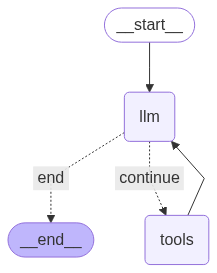

In [11]:
# Visualize the graph
display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run an Example
Let’s see the ReAct agent in action. We ask a composite question requiring both Wikipedia (population) and calculator (division).

In [12]:
# Example user query
user_question = "What is the population of Spain in 2025 divided by 2?"

# Initial state: conversation starts with user message
state = AgentState(messages=[HumanMessage(content=user_question)])

# Run the ReAct agent
result = agent.invoke(state)

# Print the conversation history
for msg in result["messages"]:
    print(f"{msg.type.upper()}: {msg.content}")

HUMAN: What is the population of Spain in 2025 divided by 2?
AI: 
TOOL: "As of 1 July 2025, Spain had a total population of 49,315,949. The modern Kingdom of Spain arose from the accretion of several independent Iberian realms, including the Kingdoms of Le\u00f3n, Castile, Navarre, the Crown of Aragon and Granada,  all of which, together with the modern state of Portugal, were successor states to the late antique Christian Visigothic Kingdom after the Reconquista.\nSpain's population surpassed 49 million inhabitants for the first time in history in 2025, with a total population of 49,315,949 people living in Spain. Its population density, at 97 inhabitants per square kilometre (250/sq mi), is much lower than other Western European countries, yet, with the exception of microstates, it has the highest real density population in Europe, based on density of inhabited areas. With the notable exception of Madrid, Spain's capital city, the most densely populated areas lie around the coast."
A

The LLM should:
- Reason: Identify it needs population → use Wikipedia.
- Act: Call `wiki_search`.
- Reason again: Take result, realize it needs math.
- Act: Call `calculator`.
- Reason finally: Give the user the answer.